## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA on a free-tier Colab Notebook 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 🪓

In [3]:
# Check the GPU
!nvidia-smi

Sat Aug 12 16:44:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.79       Driver Version: 528.79       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P3    13W /  30W |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install dependencies.
!pip install xformers bitsandbytes transformers accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.2 MB/s eta 0:00:00


Make sure to install `diffusers` from `main`.

In [3]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download diffusers SDXL DreamBooth training script.

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

## Dataset 🐶

Let's download some example images:

**Option 1:** upload example images from your local files:

In [ ]:
import os
from google.colab import files

# pick a name for the image folder
local_dir = "./dog" #@param
os.makedirs(local_dir)
os.chdir(local_dir)

# choose and upload local images into the newly created directory
uploaded_images = files.upload()
os.chdir("/content") # back to parent directory

**Option 2:** download example images from the hub:

In [5]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/content/dog'

Preview the images:

In [4]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [5]:
import glob

# change path to display images from your local dir
img_paths = "./dog/*.jpeg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Generate custom captions with BLIP
Load BLIP to auto caption your images:

In [ ]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
# load pipelines
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

## IMAGE CAPTIONING ##
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

In [ ]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./3d_icon/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix. Feel free to change the
prefix according to the concept you're training on!
- for this example we will use "In the style of TOK, " other options:
    - For faces you might want to use "photo of a TOK person"
    - For objects "a TOK..."
- You can add additional identifiers relating to your concept that can help steer the model in the right direction.
-- e.g. for this example, instead of "In the style of TOK, " we can use "a 3d icon in the style of TOK, "

In [ ]:
import json

caption_prefix = "a 3d icon in the style of TOK, " #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

Free some memory:

In [ ]:
import gc

# delete the BLIP pipelines and clear up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [8]:
!accelerate config default

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
2023-08-09 01:52:18.472128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [1]:
from huggingface_hub import notebook_login
notebook_login()

## Train! 🔬

#### Alright let's launch a training ⚡
Make sure to add `push_to_hub` so that the checkpoint is automatically pushed to the Hub and doesn't get lost.

To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* Memory-efficient attention (`--enable_xformers_memory_efficient_attention`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

The `--push_to_hub` argument ensures that the trained checkpoints are automatically pushed to the Hugging Face Hub.

**Pick a name for your trained dreambooth lora repository by changing `output_dir` 📂**

In [11]:
from argparse import Namespace
from pathlib import Path
args = Namespace(
    pretrained_model_name_or_path= "stabilityai/stable-diffusion-xl-base-1.0",#@param
    pretrained_vae_model_name_or_path= "madebyollin/sdxl-vae-fp16-fix",#@param
    push_to_hub= True, #@param

    dataset_name= None, #@param
    cache_dir=None,
    instance_data_dir = "./dog", #@param
    output_dir = 'dog_test', #@param
    instance_prompt = 'a TOK dog', #@param
    optimizer = 'prodigy',#@param
    use_8bit_adam = False,#@param
    learning_rate =1.0,#@param
    train_text_encoder = True,
    text_encoder_lr=1.0,#@param
    max_train_steps = 1000,#@param
    gradient_accumulation_steps=2,#@param
    snr_gamma=None,#@param
    repeats=1,#@param
    rank= 32,#@param
    image_column = None,
    caption_column = "prompt",

    prior_generation_precision = "fp16",
    mixed_precision= "fp16", #@param
    resolution= 1024,
    num_train_epochs=100,
    train_batch_size=1, #@param
    sample_batch_size=1,
    max_grad_norm=1.0,
    gradient_checkpointing=True, #@param  # set this to True to lower the memory usage.
    seed=0, #@param

    revision= None,
    validation_prompt= 'TOK dog at the beach',
    num_validation_images= 4,
    num_class_images= 100,
    validation_epochs= 50,

    report_to = 'tensorboard',
    logging_dir= "logs",
    hub_model_id = None,
    hub_token = Path("/root/.cache/huggingface/"),

    with_prior_preservation = False,
    class_data_dir = None,
    class_prompt=None,
    prior_loss_weight = 1.0,
    crops_coords_top_left_h = 0,
    crops_coords_top_left_w =0,
    center_crop = False,

    checkpoints_total_limit= None,
    resume_from_checkpoint = None,
    scale_lr= False,
    lr_num_cycles= 1,
    lr_power= 1.0,
    dataloader_num_workers= 0,
    adam_beta1= 0.9,
    adam_beta2= 0.999,
    adam_weight_decay= 1e-4,
    adam_weight_decay_text_encoder= 1e-3,
    adam_epsilon= 1e-08,
    prodigy_beta3 = None,
    prodigy_decouple = True,
    prodigy_use_bias_correction = True,
    prodigy_safeguard_warmup = True,
    allow_tf32= False,

    lr_warmup_steps= 100, #@param
    lr_scheduler= "constant",#@param
    enable_xformers_memory_efficient_attention = False, #@param
    checkpointing_steps=3000,


)

import os
import warnings

#let's make sure we are not missing key arguments

if args.dataset_name is None and args.instance_data_dir is None:
    raise ValueError("Specify either `--dataset_name` or `--instance_data_dir`")

if args.dataset_name is not None and args.instance_data_dir is not None:
    raise ValueError("Specify only one of `--dataset_name` or `--instance_data_dir`")

env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
if env_local_rank != -1 and env_local_rank != args.local_rank:
    args.local_rank = env_local_rank

if args.with_prior_preservation:
    if args.class_data_dir is None:
        raise ValueError("You must specify a data directory for class images.")
    if args.class_prompt is None:
        raise ValueError("You must specify prompt for class images.")
else:
    # logger is not available yet
    if args.class_data_dir is not None:
        warnings.warn("You need not use --class_data_dir without --with_prior_preservation.")
    if args.class_prompt is not None:
        warnings.warn("You need not use --class_prompt without --with_prior_preservation.")

2023-08-09 01:57:12.317799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-09 01:57:18.717349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
08/09/2023 01:57:21 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type', 'thresholding', 'clip_sample_range', 'dynamic_thresholding_ratio'} was not found in config. Values will be initialized to default values.
08/09/2023 01:58:47 - INFO - __main__ - ***** Running training *****
08/09/2023 01:58:47 - INFO - __main__ -   Num ex

### Launch training 🚀🚀🚀

In [ ]:
import train_dreambooth_lora_sdxl
from accelerate import notebook_launcher
notebook_launcher(train_dreambooth_lora_sdxl.main(args), num_processes=1)

### Check out your model 🔥

In [ ]:
from huggingface_hub import whoami
from pathlib import Path
from IPython.display import display, Markdown

username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
output_dir = "3d_icon_LoRA"
repo_id = f"{username}/{output_dir}"

link_to_model = f"https://huggingface.co/{repo_id}"

display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

Let's generate some images with it!

## Inference 🐕

In [ ]:
# clear up some memory
del vae, unet, noise_scheduler
gc.collect()
torch.cuda.empty_cache()

In [12]:
from diffusers import DiffusionPipeline
import torch

from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae, torch_dtype=torch.float16, variant="fp16",
    use_safetensors=True
)

# change repo_id to yours to generate images with your model
repo_id = "sayakpaul/lora-trained-xl-colab" # @param
pipe.load_lora_weights(repo_id)

_ = pipe.to("cuda")

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

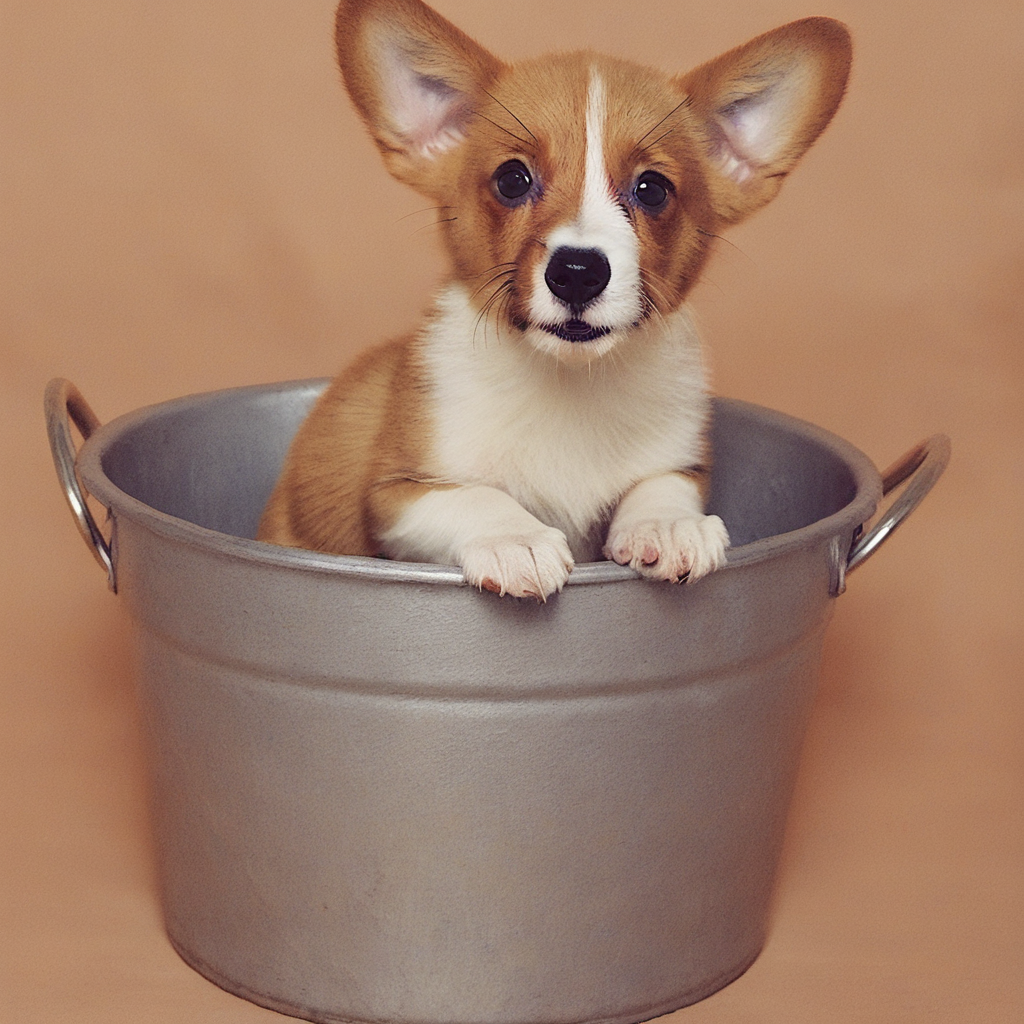

In [13]:
prompt = "a photo of sks dog in a bucket" # @param

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image